# Welcome to visualizing AWS JPSS data!
#### **Audience:** Anybody with a computer and access to at least 4GB of memory.
#### **Intent:** Build familiarity with JPSS data for use in scientific research.

##### This notebook is an introduction to accessing JPSS (SNPP, NOAA-20, and NOAA-21) satellite data from the AWS Cloud. No coding experience is required to complete this notebook, as all options are presented as Widgets, where you can select your desired product from a drop-down menu. As such, this notebook is meant for workshops, classrooms, or places where you don't want to spend time de-bugging code. If you would like to use this concept for analysis beyond an introduction, I recommend using aws_JPSS_barebones.ipynb provided alongside this notebook. 

# Importing

In [1]:
import ipywidgets as widgets
import requests
import netCDF4
import s3fs
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy import feature as cf
import xarray
from datetime import datetime
import fsspec
import h5py

# Defining

In [2]:
def aws_satellite():
    
    global satellite_choice

    # Formatting settings for drop-down menus
    style = {'description_width':'120px'}
    layout = widgets.Layout(width='325px')

    # Display drop-down menus
    print("Select the satellite you'd like to use, then run the next cell to select a date.")
    satellite_choice = widgets.Dropdown(options=[("Suomi National Polar-orbiting Partnership (NPP)","noaa-nesdis-snpp-pds"),("JPSS-1 (NOAA20)", "noaa-nesdis-n20-pds"), ("JPSS-2 (NOAA21)", "noaa-nesdis-n21-pds")], description='Satellite:', style=style, layout=layout)

    display(satellite_choice)

In [3]:
def aws_product(satellite):
    
    global product_choice
    
    # Formatting settings for drop-down menus
    style = {'description_width':'120px'}
    layout = widgets.Layout(width='325px')

    # Display drop-down menus
    print("Select the satellite product you'd like to use, then run the next cell to select a date.")
    product_choice = widgets.Dropdown(options=[("Active Fire", "VIIRS-AF-Iband-EDR"), ("Aerosol Detection Product", "VIIRS-JRR-ADP"), ("Aerosol Optical Depth", "VIIRS-JRR-AOD"),("Cloud Top Temperature","VIIRS-JRR-CloudHeight")], description='Product:', style=style, layout=layout)

    display(product_choice)

In [4]:
def aws_date(satellite, product):
    
    global year, month, day, shour, smin, ehour, emin
    
    year_options = []
    
    aws = s3fs.S3FileSystem(anon=True)
    years = aws.ls(f'{satellite}/{product}/', refresh=True)  
    for y in years:
        year_options.append(y[-4:])

    # Formatting settings for drop-down menus
    style = {'description_width':'120px'}
    layout = widgets.Layout(width='325px')
    
    year = widgets.Dropdown(options=[y for y in year_options], description='Year:', style=style, layout=layout)
    month = widgets.Dropdown(options=[('Jan', '01'), ('Feb', '02'), ('Mar', '03'), ('Apr', '04'), ('May', '05'), ('Jun', '06'), ('Jul', '07'), ('Aug', '08'), ('Sep', '09'), ('Oct', '10'), ('Nov', '11'), ('Dec', '12')], description='Month:', style=style, layout=layout)
    day = widgets.Dropdown(options=[('01'), ('02'), ('03'), ('04'), ('05'), ('06'), ('07'), ('08'), ('09'), ('10'), ('11'), ('12'), ('13'), ('14'), ('15'), ('16'), ('17'), ('18'), ('19'), ('20'), ('21'), ('22'), ('23'), ('24'), ('25'), ('26'), ('27'), ('28'), ('29'), ('30'), ('31')], description='Day:', style=style, layout=layout)
    shour = widgets.Dropdown(options=[('00'), ('01'), ('02'), ('03'), ('04'), ('05'), ('06'), ('07'), ('08'), ('09'), ('10'), ('11'), ('12'), ('13'), ('14'), ('15'), ('16'), ('17'), ('18'), ('19'), ('20'), ('21'), ('22'), ('23')], description='Start Hour:', style=style, layout=layout)
    smin = widgets.Dropdown(options=[('00'), ('01'), ('02'), ('03'), ('04'), ('05'), ('06'), ('07'), ('08'), ('09'), ('10'), ('11'), ('12'), ('13'), ('14'), ('15'), ('16'), ('17'), ('18'), ('19'), ('20'), ('21'), ('22'), ('23'), ('24'), ('25'), ('26'), ('27'), ('28'), ('29'), ('30'), ('31'), ('32'), ('33'), ('34'), ('35'), ('36'), ('37'), ('38'), ('39'), ('40'), ('41'), ('42'), ('43'), ('44'), ('45'), ('46'), ('47'), ('48'), ('49'), ('50'), ('51'), ('52'), ('53'), ('54'), ('55'), ('56'), ('57'), ('58'), ('59')], description='Start Minutes:', style=style, layout=layout)
    ehour = widgets.Dropdown(options=[('00'), ('01'), ('02'), ('03'), ('04'), ('05'), ('06'), ('07'), ('08'), ('09'), ('10'), ('11'), ('12'), ('13'), ('14'), ('15'), ('16'), ('17'), ('18'), ('19'), ('20'), ('21'), ('22'), ('23')], description='End Hour:', style=style, layout=layout)
    emin = widgets.Dropdown(options=[('00'), ('01'), ('02'), ('03'), ('04'), ('05'), ('06'), ('07'), ('08'), ('09'), ('10'), ('11'), ('12'), ('13'), ('14'), ('15'), ('16'), ('17'), ('18'), ('19'), ('20'), ('21'), ('22'), ('23'), ('24'), ('25'), ('26'), ('27'), ('28'), ('29'), ('30'), ('31'), ('32'), ('33'), ('34'), ('35'), ('36'), ('37'), ('38'), ('39'), ('40'), ('41'), ('42'), ('43'), ('44'), ('45'), ('46'), ('47'), ('48'), ('49'), ('50'), ('51'), ('52'), ('53'), ('54'), ('55'), ('56'), ('57'), ('58'), ('59')], description='End Minutes:', style=style, layout=layout)

    start_time = widgets.HBox([shour, smin])
    end_time = widgets.HBox([ehour, emin])

    print("Select your chosen date and time, chosen from the orbit track, then run the next cell.")
    
    display(year, month, day)
    display(start_time, end_time)

In [5]:
def aws_data(satellite, product, year, month, day, shour, ehour, smin, emin):

    global fnames
        
    aws = s3fs.S3FileSystem(anon=True)
    
    data_files = aws.ls(f'{satellite}/{product}/{year}/{month}/{day}/', refresh=True)  

    # Extracting files for chosen date/time
    fnames = []
    for file in data_files:
        file_start = file.split('_')[-3][9:13]
        file_end = file.split('_')[-2][9:13]        
        if ((int(file_start[0:4]) >= int((str(shour) + str(smin)))) and (int(file_end[0:4]) <= int((str(ehour) + str(emin)))) and (str(file.split('_')[-2][7:9]) == day)):
            fnames.append(file)
            
    print(f"This search produced {len(fnames)} files.")

In [14]:
def aws_plot(satellite, product):
    
    if satellite == "noaa-nesdis-snpp-pds":
        satellite_name = "SNPP"
    elif satellite == "noaa-nesdis-n20-pds":
        satellite_name = "NOAA-20"
    elif satellite == "noaa-nesdis-n21-pds":
        satellite_name = "NOAA-21"
    
    fig = plt.figure(figsize=(12, 7))
    ax = plt.axes(projection=ccrs.PlateCarree()) 
    ax.add_feature(cf.OCEAN)
    ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.25)
    ax.coastlines(resolution='50m', color='black', linewidth=0.25)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=0.05, linestyle='-')
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    
    # Active Fires!
    if product == "VIIRS-AF-Iband-EDR":
        for f in range(0, len(fnames)):
            fname = (fnames[f])[len(satellite_choice.value) + 1:]
            s3url = (f's3://{satellite}/{fname}')
            s3f = fsspec.open(s3url, mode='rb', anon=True, default_fill_cache=False)    
            h5f = h5py.File(s3f.open(), mode='r')
            dset = h5f["Fire Pixels"]
            title = "Fire Radiative Power"
            x = dset["FP_longitude"]
            y = dset["FP_latitude"]
            product_var = dset["FP_power"]
            h5f.close()
            
            scatter = ax.scatter(x, y, s=4, c = product_var, vmin = 0, vmax = 150)
        
        plt.colorbar(scatter, shrink=0.5, label = "Megawatts")
        plt.title(f"{satellite_name} {title}", loc='left', fontweight='bold')
        plt.title(f'{year.value}-{month.value}-{day.value} at {shour.value} UTC', loc='right')
        plt.show()
        plt.close("all")
        plt.close(fig)
    
    # Aerosol Optical Depth!
    elif product == "VIIRS-JRR-AOD":

        for f in range(0, len(fnames)):
            fname = (fnames[f])[len(satellite) + 1:]
            resp = requests.get(f'https://{satellite_choice.value}.s3.amazonaws.com/{fname}')
            nc = netCDF4.Dataset(fname, memory = resp.content)
            dataset = xarray.open_dataset(xarray.backends.NetCDF4DataStore(nc))
            dataset.load()

            dat = dataset.metpy.parse_cf('AOD550')
            plotting_var = dataset['AOD550'].data
            lon = dat.Longitude
            lat = dat.Latitude
            dataset.close()
            
            aerosols = ax.contourf(lon, lat, plotting_var, vmin=-0.05, vmax=5, transform=ccrs.PlateCarree())
        
        title = "Aerosol Optical Depth at 550nm"
        plt.colorbar(aerosols, shrink=0.5)
        scan_start = datetime.strptime(dataset.time_coverage_start, '%Y-%m-%dT%H:%M:%SZ')

        plt.title(f"{satellite_name} {title}", loc='left', fontweight='bold')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y at %H UTC')), loc='right')
        plt.show()
        plt.close("all")
        plt.close(fig)
        
    # Aerosol Detection!
    elif product == "VIIRS-JRR-ADP":

        for f in range(0, len(fnames)):
            fname = (fnames[f])[len(satellite) + 1:]
            resp = requests.get(f'https://{satellite_choice.value}.s3.amazonaws.com/{fname}')
            nc = netCDF4.Dataset(fname, memory = resp.content)
            dataset = xarray.open_dataset(xarray.backends.NetCDF4DataStore(nc))
            dataset.load()

            dat = dataset.metpy.parse_cf('Ash')
            
            ash = dataset['Ash'].data
            ash[ash != 1] = np.nan
            
            dust = dataset['Dust'].data
            dust[dust != 1] = np.nan
            
            cloud = dataset['Cloud'].data
            cloud[cloud != 1] = np.nan
            
            smoke = dataset['Smoke'].data
            smoke[smoke != 1] = np.nan
            
            lon = dat.Longitude
            lat = dat.Latitude

            dataset.close()
            
            ash_plot = plt.contourf(lon, lat, ash, transform=ccrs.PlateCarree(), cmap = "Greens_r")
            dust_plot = plt.contourf(lon, lat, dust, transform=ccrs.PlateCarree(), cmap = "Blues_r")
            cloud_plot = plt.contourf(lon, lat, cloud, transform=ccrs.PlateCarree(), cmap = "Greys")
            smoke_plot = plt.contourf(lon, lat, smoke, transform=ccrs.PlateCarree(), cmap = "Reds_r")
            
        title = "Aerosol Detection Product"
        scan_start = datetime.strptime(dataset.time_coverage_start, '%Y-%m-%dT%H:%M:%SZ')

        h1,_ = ash_plot.legend_elements()
        h2,_ = dust_plot.legend_elements()
        h3,_ = cloud_plot.legend_elements()
        h4,_ = smoke_plot.legend_elements()
        ax.legend([h1[0], h2[0], h3[0], h4[0]], ['Ash', 'Dust', 'Cloud', 'Smoke'], loc = 'lower right')

        plt.title(f"{satellite_name} {title}", loc='left', fontweight='bold')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y at %H UTC')), loc='right')
        plt.show()
        plt.close('all')
        plt.close(fig)
    
    # Cloud Top Temperature! 
    elif product == "VIIRS-JRR-CloudHeight": 
        for f in range(0, len(fnames)):
            fname = (fnames[f])[len(satellite) + 1:]
            resp = requests.get(f'https://{satellite_choice.value}.s3.amazonaws.com/{fname}')
            nc = netCDF4.Dataset(fname, memory = resp.content)
            dataset = xarray.open_dataset(xarray.backends.NetCDF4DataStore(nc))
            dataset.load()
            
            dat = dataset.metpy.parse_cf('CldTopTemp')
            plotting_var = dataset['CldTopTemp'].data - 273.15
            lon = dat.Longitude
            lat = dat.Latitude
            nc.close()
            
            temps = ax.contourf(lon, lat, plotting_var, vmin = -80, vmax = 40, transform=ccrs.PlateCarree())

        title = "Cloud Top Temperature"
        plt.colorbar(temps, shrink=0.5)
        scan_start = datetime.strptime(dataset.time_coverage_start, '%Y-%m-%dT%H:%M:%SZ')

        plt.title(f"{satellite_name} {title}", loc='left', fontweight='bold')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y at %H UTC')), loc='right')
        plt.show()
        plt.close("all")
        plt.close(fig)

# Choosing your variables

In [7]:
aws_satellite()

Select the satellite you'd like to use, then run the next cell to select a date.


Dropdown(description='Satellite:', layout=Layout(width='325px'), options=(('Suomi National Polar-orbiting Part…

In [8]:
aws_product(satellite_choice.value)

Select the satellite product you'd like to use, then run the next cell to select a date.


Dropdown(description='Product:', layout=Layout(width='325px'), options=(('Active Fire', 'VIIRS-AF-Iband-EDR'),…

### Find orbit track: 
The AWS cloud contains VIIRS Level 2 data, which is visualized in swaths, or the image the satellite takes as it passes over a location. As a result, it is necessary to determine the time the satellite crossed over a location in order to download and plot the swath data of interest. If this step is skipped, you might have to look through thousands of swath files from a single day in order to get the image you're interested in.

#### This link plots the crossover times of each satellite: https://www.ssec.wisc.edu/datacenter/polar_orbit_tracks/
1. Open the above link, which takes you to the Space Science and Engineering Center webpage hosted by the University of Wisconsin-Madison.
2. Scroll down to "Orbit Track Links", and select your chosen satellite (either NPP or NOAA20) from the options under "All Satellites."
3. At the top of the following page, click the "___ Archive" button, where the blank space has the name of your chosen satellite.
4. Follow the links to select your date (year_month_day) of interest. Open the directory containing your day.
5. Select the geographic region of interest.
6. Each white line on the displayed figure represents the center of your satellite's orbit. Locate your region of interest, then follow the white line north and south to get the time range of your satellite's crossover. 
7. In the next cell, select your chosen date, then enter the start and end time of your satellite crossover.

In [9]:
aws_date(satellite_choice.value, product_choice.value)

Select your chosen date and time, chosen from the orbit track, then run the next cell.


Dropdown(description='Year:', layout=Layout(width='325px'), options=('2023',), style=DescriptionStyle(descript…

Dropdown(description='Month:', layout=Layout(width='325px'), options=(('Jan', '01'), ('Feb', '02'), ('Mar', '0…

Dropdown(description='Day:', layout=Layout(width='325px'), options=('01', '02', '03', '04', '05', '06', '07', …

In [16]:
aws_data(satellite_choice.value, product_choice.value, year.value, month.value, day.value, shour.value, ehour.value, smin.value, emin.value)

This search produced 4 files.


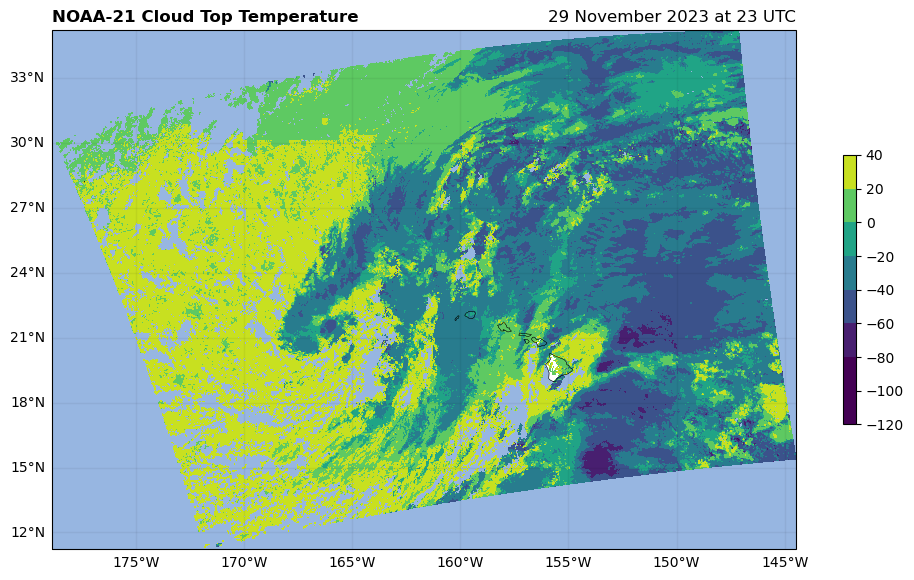

In [17]:
aws_plot(satellite_choice.value, product_choice.value)

In [ ]:
# Your analysis here!

# Resources

**JPSS Product Documentation:**
- https://www.star.nesdis.noaa.gov/jpss/JPSS_products.php (Product description)
- https://www.ospo.noaa.gov/Products/Suites/jpss-rr/count_JRR_product.html?product=aerosol (JRR product visualization)
- https://www.nesdis.noaa.gov/our-satellites/currently-flying/joint-polar-satellite-system/jpss-satellite-and-instruments (About the satellites)
- https://rammb2.cira.colostate.edu/training/visit/jpss-imagery-for-users/ (Data visualization)
- https://weather.ndc.nasa.gov/sport/jpsspg/viirs.html (Real-time product visualization)

**Coding Sources:**
- https://github.com/jpss-nodd/python-scripts/tree/main
- https://medium.com/the-barometer/plotting-noaa-dnb-nighttime-data-using-python-h5py-cartopy-daefef240b0f
- https://github.com/modern-tools-workshop/AMS-python-workshop-2023
- https://www.meted.ucar.edu/education_training/course/54
- https://www.star.nesdis.noaa.gov/atmospheric-composition-training/python_abi_level2_download.php

**CSP Access:**    
AWS: https://registry.opendata.aws/noaa-jpss/    
Google: coming soon...    
Azure: coming soon...